In [1]:
import ND_north_star.src.noise_generators.perlin_noise_generator as PNG

import ND_north_star.src.edge_detection.complex as ED_com
from ND_north_star.src.edge_detection.contour_points_2D import find_boundary_points, group_distinct_boundary_curves, generate_spline_curve, generate_boundary_splines
import ND_north_star.src.edge_detection.gradient_detection as ED_sim

from ND_north_star.src.utils.sampling_function import random_sampler, dual_sampler


In [2]:
resolution = 80
dimensions = [resolution, resolution]

full_dataset = PNG.normalized_perlin_data(dimensions, 2)

# Plot perlin noise coord in x and y coordinates and with intensity values surrounded by a black outline
# PNG.plot_perlin_2D_3D(full_dataset, 'black')

# dataset = random_sampler(full_dataset, 200)
# PNG.plot_perlin_2D_3D(dataset, 'black')

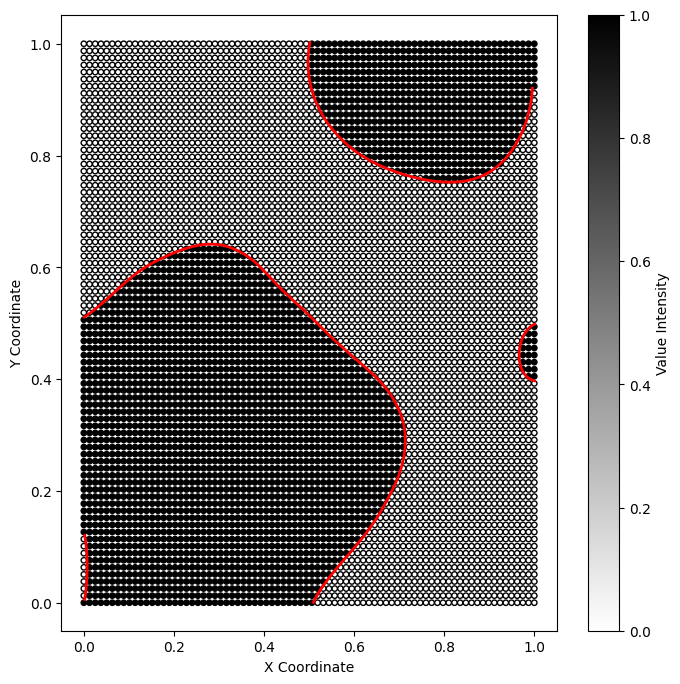

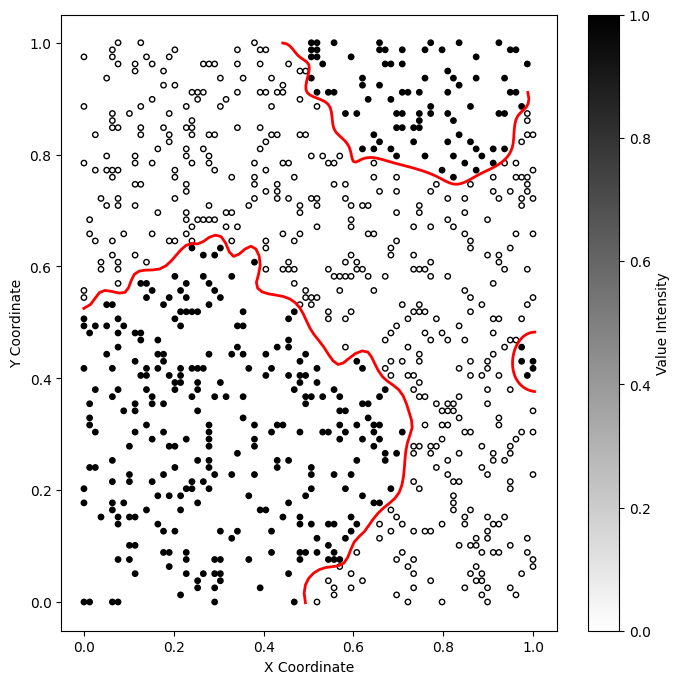

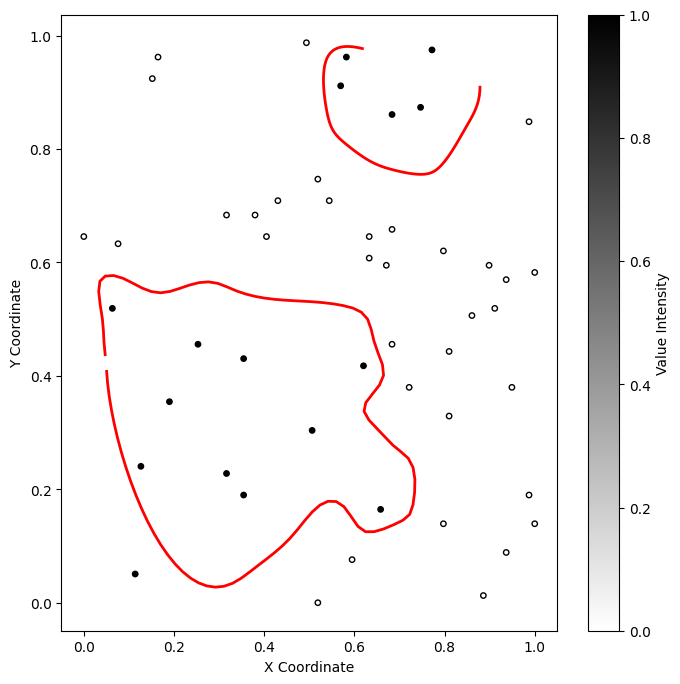

In [11]:


boundary_splines = generate_boundary_splines(full_dataset)
full_dataset['boundary_splines'] = boundary_splines
PNG.plot_perlin_2D_3D(full_dataset, 'black')

close_dataset = random_sampler(full_dataset, 800)
boundary_splines = generate_boundary_splines(close_dataset)
close_dataset['boundary_splines'] = boundary_splines
PNG.plot_perlin_2D_3D(close_dataset, 'black')


sparse_dataset = random_sampler(full_dataset, 50)
boundary_splines = generate_boundary_splines(sparse_dataset)
sparse_dataset['boundary_splines'] = boundary_splines
PNG.plot_perlin_2D_3D(sparse_dataset, 'black')





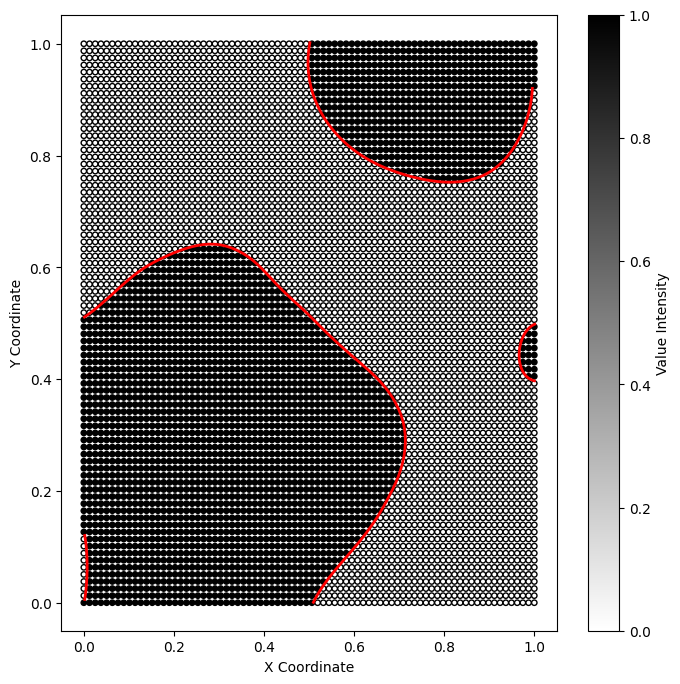

{'features': array([[0.41772152, 0.83544304],
       [0.64556962, 0.60759494],
       [0.97468354, 0.41772152],
       [0.48101266, 0.94936709],
       [0.27848101, 0.05063291],
       [0.39240506, 0.03797468],
       [0.15189873, 0.86075949],
       [0.91139241, 0.65822785],
       [0.82278481, 0.06329114],
       [0.27848101, 0.34177215],
       [0.20253165, 0.6835443 ],
       [0.67088608, 0.08860759],
       [0.63291139, 0.10126582],
       [0.05063291, 0.72151899],
       [0.5443038 , 0.26582278],
       [0.07594937, 0.27848101],
       [0.24050633, 0.16455696],
       [0.05063291, 0.81012658],
       [0.79746835, 0.43037975],
       [0.20253165, 0.53164557],
       [0.81012658, 0.05063291],
       [0.20253165, 0.10126582],
       [0.06329114, 0.18987342],
       [0.29113924, 0.81012658],
       [0.        , 0.63291139],
       [0.91139241, 0.11392405],
       [0.49367089, 0.        ],
       [0.05063291, 0.36708861],
       [0.98734177, 0.93670886],
       [0.58227848, 0.62025316

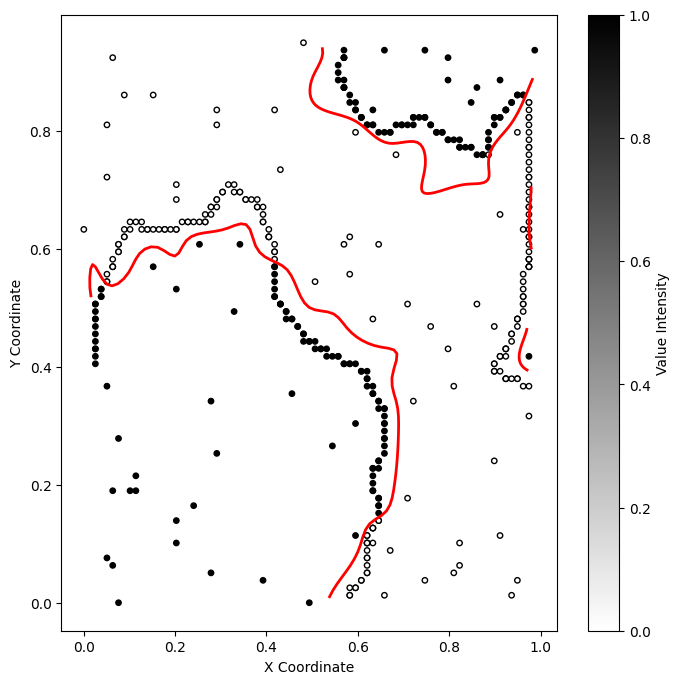

{'features': array([[0.69620253, 0.44303797],
       [0.70886076, 0.30379747],
       [0.41772152, 0.81012658],
       [0.17721519, 0.78481013],
       [0.59493671, 0.15189873],
       [0.39240506, 0.44303797],
       [0.82278481, 0.74683544],
       [0.98734177, 0.08860759],
       [0.10126582, 0.81012658],
       [0.53164557, 0.11392405]]), 'values': array([0, 1, 0, 0, 1, 1, 0, 0, 0, 1]), 'resolution': [80, 80], 'coordinates': ['x0', 'x1'], 'octaves': 2, 'dimension': 2, 'distinct_boundary_points': {0: array([[ 5.71982127e-07,  6.32911392e-03],
       [ 3.77111868e-03,  1.01010101e-02],
       [ 6.32918590e-03,  2.02020202e-02],
       [ 6.32902565e-03,  3.03030303e-02],
       [ 6.32927417e-03,  4.04040404e-02],
       [ 6.32932925e-03,  5.05050505e-02],
       [ 6.32860436e-03,  6.06060606e-02],
       [ 6.32830773e-03,  7.07070707e-02],
       [ 6.32970352e-03,  8.08080808e-02],
       [ 6.32817018e-03,  9.09090909e-02],
       [ 6.32973363e-03,  1.01010101e-01],
       [ 6.3287600

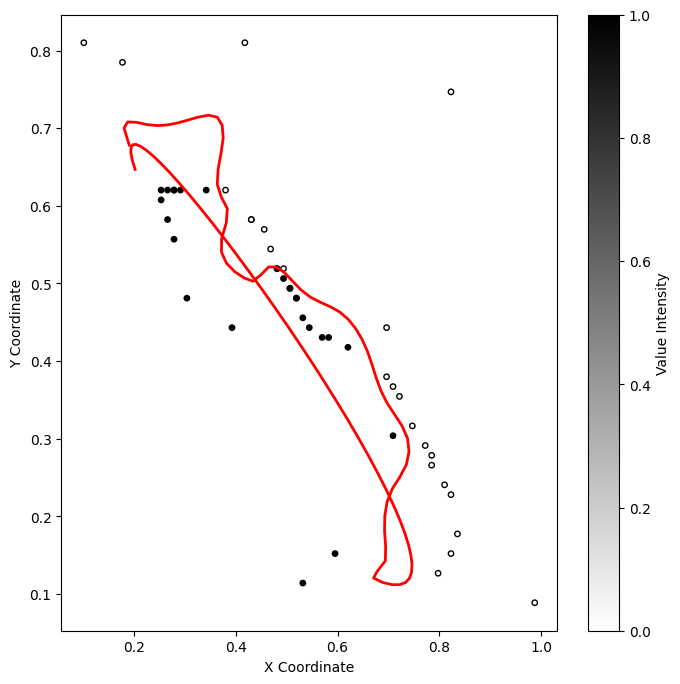

In [16]:


boundary_splines = generate_boundary_splines(full_dataset)
full_dataset['boundary_splines'] = boundary_splines
PNG.plot_perlin_2D_3D(full_dataset, 'black')

close_dataset = dual_sampler(full_dataset, 800, .1)

print(len(close_dataset['features']))
boundary_splines = generate_boundary_splines(close_dataset)
close_dataset['boundary_splines'] = boundary_splines
PNG.plot_perlin_2D_3D(close_dataset, 'black')


sparse_dataset = dual_sampler(full_dataset, 50, .2)

print(len(sparse_dataset['features']))
boundary_splines = generate_boundary_splines(sparse_dataset)
sparse_dataset['boundary_splines'] = boundary_splines
PNG.plot_perlin_2D_3D(sparse_dataset, 'black')





In [5]:
print(full_dataset['boundary_splines'])

{0: array([[0.00197725, 0.00587332],
       [0.00218341, 0.00693237],
       [0.00238563, 0.00799758],
       [0.00258393, 0.00906882],
       [0.00277828, 0.01014596],
       [0.00296868, 0.01122886],
       [0.00315513, 0.0123174 ],
       [0.0033376 , 0.01341144],
       [0.00351611, 0.01451086],
       [0.00369063, 0.01561554],
       [0.00386116, 0.01672533],
       [0.00402769, 0.0178401 ],
       [0.00419021, 0.01895974],
       [0.00434872, 0.0200841 ],
       [0.0045032 , 0.02121307],
       [0.00465365, 0.0223465 ],
       [0.00480007, 0.02348427],
       [0.00494243, 0.02462625],
       [0.00508074, 0.02577232],
       [0.00521498, 0.02692233],
       [0.00534514, 0.02807616],
       [0.00547123, 0.02923368],
       [0.00559323, 0.03039476],
       [0.00571113, 0.03155928],
       [0.00582492, 0.03272709],
       [0.0059346 , 0.03389808],
       [0.00604015, 0.0350721 ],
       [0.00614158, 0.03624904],
       [0.00623886, 0.03742876],
       [0.006332  , 0.03861114],
      

In [6]:
import numpy as np

merged_array = np.concatenate(list(full_dataset['boundary_splines'].values()), axis=0)
print(merged_array)

[[1.97725433e-03 5.87331827e-03]
 [2.18340660e-03 6.93237276e-03]
 [2.38563371e-03 7.99758362e-03]
 [2.58392745e-03 9.06882107e-03]
 [2.77827959e-03 1.01459553e-02]
 [2.96868190e-03 1.12288566e-02]
 [3.15512615e-03 1.23173950e-02]
 [3.33760414e-03 1.34114409e-02]
 [3.51610761e-03 1.45108645e-02]
 [3.69062837e-03 1.56155359e-02]
 [3.86115816e-03 1.67253253e-02]
 [4.02768878e-03 1.78401031e-02]
 [4.19021200e-03 1.89597393e-02]
 [4.34871959e-03 2.00841041e-02]
 [4.50320333e-03 2.12130679e-02]
 [4.65365499e-03 2.23465008e-02]
 [4.80006634e-03 2.34842731e-02]
 [4.94242917e-03 2.46262548e-02]
 [5.08073524e-03 2.57723163e-02]
 [5.21497634e-03 2.69223278e-02]
 [5.34514423e-03 2.80761594e-02]
 [5.47123069e-03 2.92336814e-02]
 [5.59322749e-03 3.03947639e-02]
 [5.71112642e-03 3.15592773e-02]
 [5.82491924e-03 3.27270917e-02]
 [5.93459773e-03 3.38980772e-02]
 [6.04015367e-03 3.50721042e-02]
 [6.14157882e-03 3.62490429e-02]
 [6.23886497e-03 3.74287634e-02]
 [6.33200389e-03 3.86111359e-02]
 [6.420987

In [7]:
import numpy as np
from hausdorff import hausdorff_distance

ind = 2

X1 = np.concatenate(list(full_dataset['boundary_splines'].values()), axis=0)
X2 = np.concatenate(list(close_dataset['boundary_splines'].values()), axis=0)
X3 = np.concatenate(list(sparse_dataset['boundary_splines'].values()), axis=0)

# print(X.shape)

print(f"Hausdorff distance test: {hausdorff_distance(X1, X2, distance='euclidean')}")
print(f"Hausdorff distance test: {hausdorff_distance(X1, X3, distance='euclidean')}")


ModuleNotFoundError: No module named 'hausdorff'

In [ ]:
import numpy as np
from hausdorff import hausdorff_distance

# two random 2D arrays (second dimension must match)
np.random.seed(0)



X = full_dataset['boundary_splines'][0]
Y = dataset['boundary_splines'][0]

print(X.shape)
# print(X)

# Test computation of Hausdorff distance with different base distances
# print(f"Hausdorff distance test: {hausdorff_distance(X, Y, distance='manhattan')}")
print(f"Hausdorff distance test: {hausdorff_distance(X, Y, distance='euclidean')}")
# print(f"Hausdorff distance test: {hausdorff_distance(X, Y, distance='chebyshev')}")
# print(f"Hausdorff distance test: {hausdorff_distance(X, Y, distance='cosine')}")

# # For haversine, use 2D lat, lng coordinates
# def rand_lat_lng(N):
#     lats = np.random.uniform(-90, 90, N)
#     lngs = np.random.uniform(-180, 180, N)
#     return np.stack([lats, lngs], axis=-1)
        
# X = rand_lat_lng(100)
# Y = rand_lat_lng(250)
# print("Hausdorff haversine test: {0}".format( hausdorff_distance(X, Y, distance="haversine") ))

NameError: name 'dataset' is not defined

In [ ]:
import numpy as np
from hausdorff import hausdorff_distance

# two random 2D arrays (second dimension must match)
np.random.seed(0)
X = np.random.random((1000,2))
Y = np.random.random((5000,2))

print(X.shape)
print(X)

# Test computation of Hausdorff distance with different base distances
print(f"Hausdorff distance test: {hausdorff_distance(X, Y, distance='manhattan')}")
print(f"Hausdorff distance test: {hausdorff_distance(X, Y, distance='euclidean')}")
print(f"Hausdorff distance test: {hausdorff_distance(X, Y, distance='chebyshev')}")
print(f"Hausdorff distance test: {hausdorff_distance(X, Y, distance='cosine')}")

# For haversine, use 2D lat, lng coordinates
def rand_lat_lng(N):
    lats = np.random.uniform(-90, 90, N)
    lngs = np.random.uniform(-180, 180, N)
    return np.stack([lats, lngs], axis=-1)
        
X = rand_lat_lng(100)
Y = rand_lat_lng(250)
print("Hausdorff haversine test: {0}".format( hausdorff_distance(X, Y, distance="haversine") ))

(1000, 2)
[[0.5488135  0.71518937]
 [0.60276338 0.54488318]
 [0.4236548  0.64589411]
 ...
 [0.41443887 0.79128155]
 [0.72119811 0.48010781]
 [0.64386404 0.50177313]]
Hausdorff distance test: 0.062454548094708184
Hausdorff distance test: 0.053084345565014415
Hausdorff distance test: 0.05223899206749627
Hausdorff distance test: 1.5204074512387145e-05
Hausdorff haversine test: 2788.207575653002


In [ ]:
import matplotlib.pyplot as plt

X = boundary_points[:, 0]
Y = boundary_points[:, 1]

plt.scatter(X, Y, s=3)
plt.show()

NameError: name 'boundary_points' is not defined

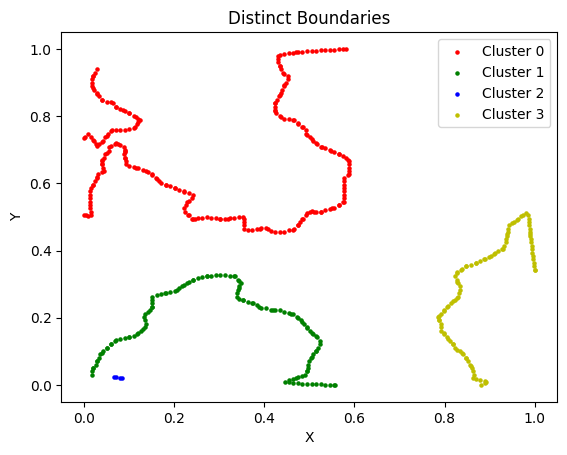

In [ ]:

distinct_boundaries = group_distinct_boundary_curves(boundary_points)

# Plotting the results to visualize the clusters
colors = ['r', 'g', 'b', 'y', 'c', 'm']
for label, boundary in distinct_boundaries.items():
    if label == -1:
        color = 'k'  # Noise points
    else:
        color = colors[label % len(colors)]
        plt.scatter(boundary[:, 0], boundary[:, 1], c=color, label=f'Cluster {label}', s=5)
        # plt.show()

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Distinct Boundaries')
plt.legend()
plt.show()

# # Print distinct boundaries
# for label, boundary in distinct_boundaries.items():
#     print(f"Boundary {label}:")
#     print(boundary)

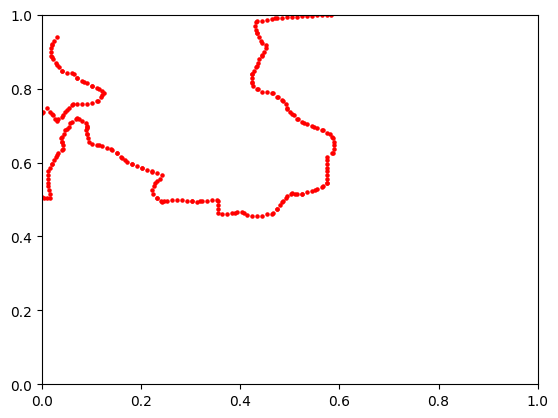

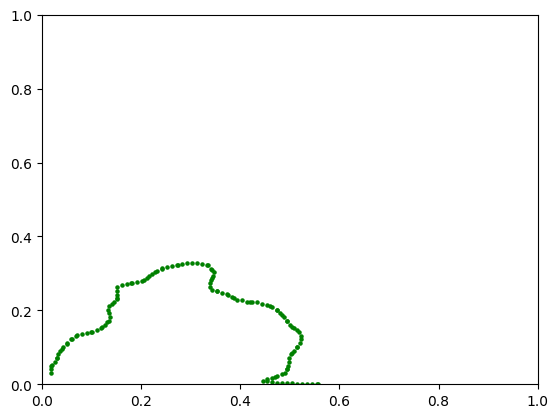

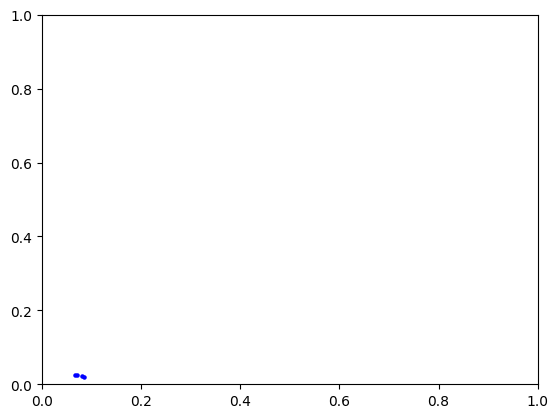

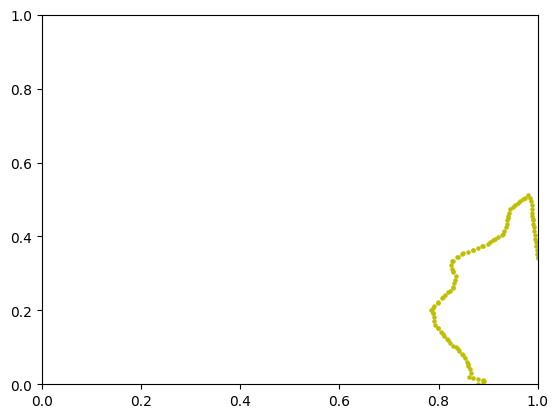

In [ ]:

distinct_boundaries = group_distinct_boundary_curves(boundary_points)

# Plotting the results to visualize the clusters
colors = ['r', 'g', 'b', 'y', 'c', 'm']
for label, boundary in distinct_boundaries.items():
    if label == -1:
        color = 'k'  # Noise points
    else:
        color = colors[label % len(colors)]
        plt.scatter(boundary[:, 0], boundary[:, 1], c=color, label=f'Cluster {label}', s=5)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.show()

# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('Distinct Boundaries')
# plt.legend()
# plt.show()


In [ ]:
# print(len(distinct_boundaries))
# print(distinct_boundaries.keys())
# print(distinct_boundaries)


265 265
50 50


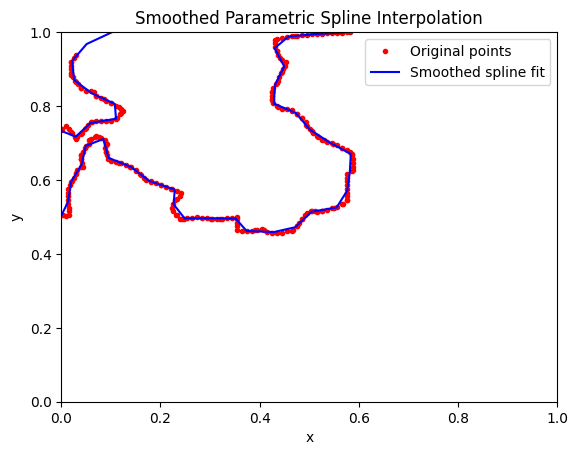

133 133
50 50


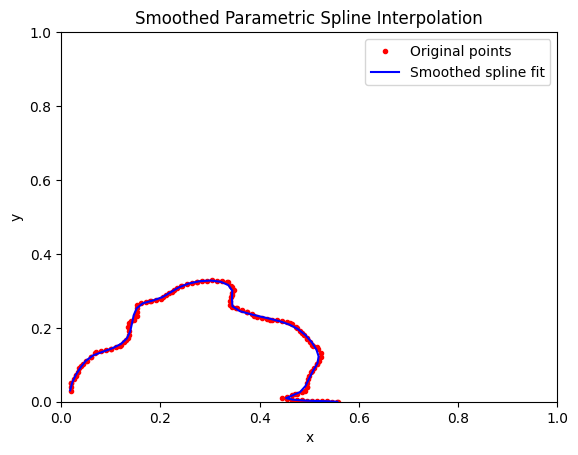

4 4
50 50


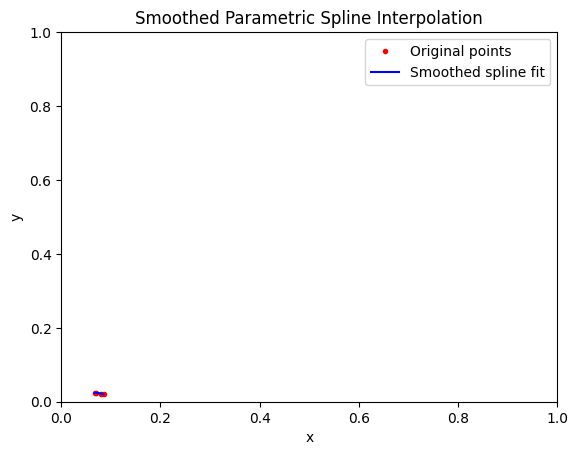

104 104
50 50


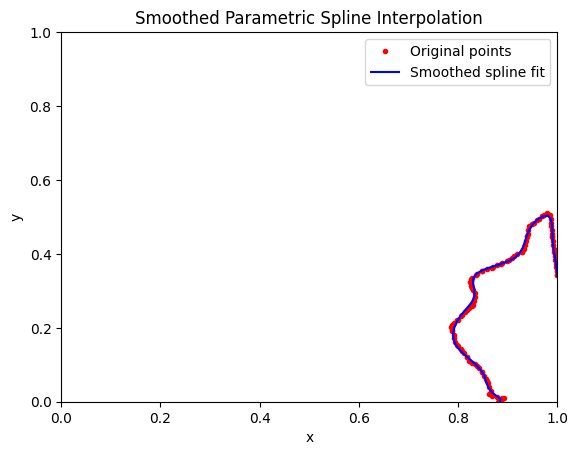

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.interpolate import splprep, splev



# def generate_spline_curve(points, smoothing_factor=0.001, num_points=100):

#     # Split data into x and y coordinates
#     x = points[:, 0]
#     y = points[:, 1]

#     # Parameterize the points with a parameter t
#     t = np.linspace(0, 1, len(points))

#     # Fit splines to x(t) and y(t) with smoothing factor s
#     # smoothing_factor = .001  # Adjust this value for more or less smoothing
#     tck, u = splprep([x, y], s=smoothing_factor)

#     # Evaluate the spline fit at a dense set of parameter values
#     # num_points = 100  # Number of points in the final smoothed curve
#     x_new, y_new = splev(np.linspace(0, 1, num_points), tck)

#     return x_new, y_new





for ind, points in distinct_boundaries.items():
# # Sample data points
# points = distinct_boundaries[4]  # Adjust this based on your actual data

    x = points[:, 0]
    y = points[:, 1]
    
    x_new, y_new = generate_spline_curve(points, smoothing_factor=0.001, num_points=50)

    print(len(x), len(y))
    print(len(x_new), len(y_new))

    # Plot the original points and the fitted curve
    plt.figure()
    plt.plot(x, y, 'ro', label='Original points', markersize=3)
    plt.plot(x_new, y_new, 'b-', label='Smoothed spline fit')
    plt.legend()
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Smoothed Parametric Spline Interpolation')
    plt.show()